In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
%load_ext autoreload
%autoreload 2
print(torch.__version__)
# My take on the solutions. Mostly copied and modified so as to work in the GPU

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.3.1


In [77]:
# Check if using GPU
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
def check_mem_usage(device):
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda



In [78]:
# Defining a toy dataset
x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168], 
                    [9.779], [6.182], [7.59], [2.167], [7.042], 
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)

y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573], 
                    [3.366], [2.596], [2.53], [1.221], [2.827], 
                        [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)

## Linear regression

In [79]:
class MyLinearRegression:
    def __init__(self):
        # Define the parameters of the model (weights and biases)
        self.weights = Variable(torch.zeros(1, device = device), requires_grad=True)
        self.bias = Variable(torch.zeros(1, device=device), requires_grad = True)
    
    def forward(self, x):
        # implement forward computation - compute predictions based on the inputs
        return self.weights * x + self.bias #pytorch overrides operators appropiately
    
    def parameters(self):
        # this function returns a list of parameters of the model
        return [self.weights, self.bias]
    
    def __call__(self, x):
        # Convenience function
        return self.forward(x)
    

def mselossfunc(pred, y):
    # TODO: implement the MSE loss function
    return (pred - y).pow(2).mean()

model = MyLinearRegression()
numpy_inputs = np.asarray([0.0, 1.0, 2.0], dtype = np.float32)
torch_inputs = Variable(torch.from_numpy(numpy_inputs)).cuda()
torch_outputs = model(torch_inputs)
print("Testing model: an input of %s gives a prediction:\n %s" % (numpy_inputs, torch_outputs))

Testing model: an input of [0. 1. 2.] gives a prediction:
 tensor([0., 0., 0.], device='cuda:0', grad_fn=<AddBackward0>)


In [80]:
def train(features, labels, model, lossfunc, optimizer, num_epoch):

    for epoch in range(num_epoch):
        # Step 1 - create torch variables corresponding to features and labels
        torch_features = Variable(torch.from_numpy(features)).cuda()
        torch_labels = Variable(torch.from_numpy(labels)).cuda()

        # Step 2 - compute model predictions and loss
        predictions = model(torch_features)
        loss = mselossfunc(predictions, torch_labels)
        
        
        # Step 3 - do a backward pass and a gradient update step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 50 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epoch, loss.item()))
        
        
def visualize(x_train, y_train, model):
    # A convenience function for visualizing predictions given by the model

    predicted = model(Variable(torch.from_numpy(x_train)).cuda()).cpu().data.numpy()
    order = np.argsort(x_train, axis = 0)
    plt.plot(x_train[order].flatten(), y_train[order].flatten(), 'ro', label='Original data')
    plt.plot(x_train[order].flatten(), predicted[order].flatten(), label='Fitted line')
    plt.legend()
    plt.show()

Epoch [1/500], Loss: 5.9467
Epoch [51/500], Loss: 0.2180
Epoch [101/500], Loss: 0.2069
Epoch [151/500], Loss: 0.1983
Epoch [201/500], Loss: 0.1916
Epoch [251/500], Loss: 0.1865
Epoch [301/500], Loss: 0.1825
Epoch [351/500], Loss: 0.1794
Epoch [401/500], Loss: 0.1770
Epoch [451/500], Loss: 0.1752


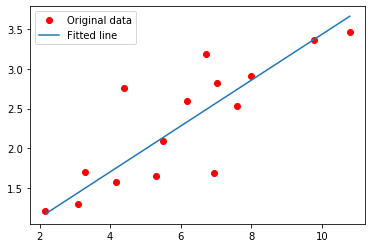

In [81]:
# Training and visualizing predictions made by linear regression model
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

train(features = x_train,
      labels = y_train,
      model = model,
      lossfunc = mselossfunc, 
      optimizer = optimizer,
      num_epoch = 500)
visualize(x_train, y_train, model)

## Linear Regression (using nn package)

Epoch [1/500], Loss: 21.0104
Epoch [51/500], Loss: 0.2140
Epoch [101/500], Loss: 0.2104
Epoch [151/500], Loss: 0.2094
Epoch [201/500], Loss: 0.2083
Epoch [251/500], Loss: 0.2073
Epoch [301/500], Loss: 0.2064
Epoch [351/500], Loss: 0.2054
Epoch [401/500], Loss: 0.2045
Epoch [451/500], Loss: 0.2036


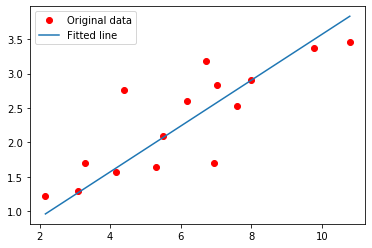

In [82]:
class NNLinearRegression(nn.Module):
    def __init__(self):
        super(NNLinearRegression, self).__init__()
        # TODO: Define the parameters of the model (linear nn layer)
        self.linear = nn.Linear(1, 1).cuda()
    def forward(self, x):
        # TODO: implement forward computation
        return self.linear.forward(x)
    
# Training and visualizing predictions made by linear regression model (nn package)
# TODO: use loss function from nn package
lossfunc = nn.MSELoss

model = NNLinearRegression()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

train(features = x_train,
      labels = y_train,
      model = model,
      lossfunc = lossfunc,
      optimizer = optimizer,
      num_epoch = 500)
visualize(x_train, y_train, model)

## MLP

Epoch [1/500], Loss: 5.3495
Epoch [51/500], Loss: 0.5352
Epoch [101/500], Loss: 0.3615
Epoch [151/500], Loss: 0.1764
Epoch [201/500], Loss: 0.1743
Epoch [251/500], Loss: 0.1740
Epoch [301/500], Loss: 0.1736
Epoch [351/500], Loss: 0.1733
Epoch [401/500], Loss: 0.1730
Epoch [451/500], Loss: 0.1727


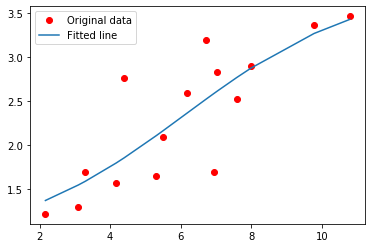

In [109]:
class MLP(nn.Module):
    def __init__(self, hidden_size):
        super(MLP, self).__init__()
        # TODO: Define parameters / layers of a multi-layered perceptron with one hidden layer
        self.input_fc = nn.Linear(1, hidden_size).cuda()
        self.activation = nn.Sigmoid().cuda()
        self.output_fc = nn.Linear(hidden_size, 1).cuda()
    
    def forward(self, x):
        return self.output_fc(self.activation(self.input_fc(x)))
    
# TODO: Play with learning rate, hidden size, and optimizer type for multi-layered perceptron
hidden_size = 2
learning_rate = 1e-1


model = MLP(hidden_size = hidden_size)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #Adam behaves better than SGD

train(features = x_train,
      labels = y_train,
      model = model,
      lossfunc = lossfunc,
      optimizer = optimizer,
      num_epoch = 500)
visualize(x_train, y_train, model)